In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

from time import time


In [2]:
model_data = pd.read_csv('model.csv')

In [3]:
model_data.head()

,subreddit,author,date,post,clean,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,is_suicide
0,depression,hanngapoi,2018/01/01,school makes me suicidal (please help) im a 16...,school make suicidal please help year old girl...,0,9.0,0.6241,"help, know, tell, need, want, think, talk, pos...","['school', 'make', 'suicidal', 'help', 'year',...",1
1,depression,thr0w4w4y989897,2018/01/01,I give up. Failed I just want to wipe my hands...,give fail want wipe hand clean bare minimum re...,1,0.0,0.5127,"life, want, live, know, think, kill, anymore, ...","['fail', 'want', 'wipe', 'hand', 'clean', 'bar...",1
2,depression,mooseman1800,2018/01/01,"depressed over the holidays No calls, messages...",depress holiday call message email holiday lif...,2,10.0,0.6203,"friends, talk, friend, want, know, people, lov...","['depress', 'holiday', 'call', 'message', 'ema...",0
3,depression,throwaway1802360,2018/01/01,It’s hard I don’t want to go back to school th...,hard dont want back school week hard alone sch...,3,10.0,0.4170,"friends, talk, friend, want, know, people, lov...","['hard', 'want', 'school', 'week', 'hard', 'sc...",0
4,depression,atemylife,2018/01/01,Year in Pixels I'm going to be doing one of th...,year pixels one year pixels things track much ...,4,13.0,0.3861,"school, college, class, high, year, grade, stu...","['year', 'pixels', 'go', 'year', 'pixels', 'th...",0


In [4]:
model_data.dropna(inplace = True)

## Grid Search for Best Params for TF-IDF/Count

In [5]:
def gridsearch_multi(steps_titles, steps_list, pipe_params):

    #Defining variables
    X = model_data['clean']
    y = model_data['is_suicide']

    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # DATAFRAME TO DISPLAY RESULTS
    gs_results = pd.DataFrame(columns=['model','AUC Score', 'precision', 'recall (sensitivity)', 
                                       'best_params', 'best score', 'confusion matrix', 
                                       'train_accuracy','test_accuracy','specificity', 'f1-score'])

    # FOR LOOP THROUGH STEPS LIST
    for i in range(len(steps_list)):
        # INSTATIATE PIPELINE
        pipe = Pipeline(steps=steps_list[i])
        # INSTANTIATE GRIDSEARCHCV WITH PARAMETER ARGUMENT
        gs = GridSearchCV(pipe, pipe_params[i], cv=3) 
        gs.fit(X_train, y_train)
        
        #GETTING PREDICTIONS FROM MODEL
        pred = gs.predict(X_test)
        
        # DEFINE CONFUSION MATRIX ELEMENTS
        tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel() 
        
        #CREATING A DICTIONARY FROM THE CLASSIFICATION REPORT(WE'LL DRAW SOME METRICS FROM HERE)
        classi_dict = (classification_report(y_test,pred, output_dict=True))
        
        #CALCULATING AREA UNDER THE CURVE
        gs.predict_proba(X_test)
        pred_proba = [i[1] for i in gs.predict_proba(X_test)] 
        auc = roc_auc_score(y_test, pred_proba)
        
        #DEFINE DATAFRAME COLUMNS
        model_results = {}
        model_results['model'] = steps_titles[i]
        model_results['AUC Score'] = auc
        model_results['precision']= classi_dict['weighted avg']['precision']
        model_results['recall (sensitivity)']= classi_dict['weighted avg']['recall']
        model_results['best params'] = gs.best_params_
        model_results['best score'] = gs.best_score_
        model_results['confusion matrix']={"TP": tp,"FP":fp, "TN": tn, "FN": fn}
        model_results['train accuracy'] = gs.score(X_train, y_train)
        model_results['test accuracy'] = gs.score(X_test, y_test)
        
        model_results['specificity']= tn/(tn+fp)  
        model_results['f1-score']= classi_dict['weighted avg']['f1-score']
        
        #APPEND RESULTS TO A NICE DATAFRAME
        df_list.append(model_results) 
        pd.set_option("display.max_colwidth", 200)
        
    return (pd.DataFrame(df_list)).round(2)

In [6]:
#USING THE FUNCTION WITH COUNT VECTORIZOR

# EMPTY LIST THAT WILL HOLD RESULTS
df_list=[]

# LIST OF MODELS
steps_titles = ['cvec+ multi_nb','cvec + ss + knn','cvec + ss + logreg','cvec + ss + rf']

# CODE FOR PIPELINE TO INSTATIATE MODELS
steps_list = [ 
    [('cv', CountVectorizer()),('multi_nb', 53MultinomialNB())],
    [('cv', CountVectorizer()),('scaler', StandardScaler(with_mean=False)),('knn', KNeighborsClassifier())], 
    [('cv', CountVectorizer()),('scaler', StandardScaler(with_mean=False)),('logreg', LogisticRegression())],
    [('cv', CountVectorizer()),('scaler', StandardScaler(with_mean=False)),('rf', RandomForestClassifier())]
]

# LIST OF PARAMETER DICTIONARIES
pipe_params = [
    {'cv__stop_words':['english'], 'cv__ngram_range':[(1,1),(1,2)],'cv__max_features': [20, 30, 50],'cv__min_df': [2, 3],'cv__max_df': [.2, .25, .3]},
    {'cv__stop_words':['english'], 'cv__ngram_range':[(1,1),(1,2)],'cv__max_features': [20, 30, 50],'cv__min_df': [2, 3],'cv__max_df': [.2, .25, .3]},
    {'cv__stop_words':['english'], 'cv__ngram_range':[(1,1),(1,2)],'cv__max_features': [20, 30, 50],'cv__min_df': [2, 3],'cv__max_df': [.2, .25, .3]},
    {'cv__stop_words':['english'], 'cv__ngram_range':[(1,1),(1,2)],'cv__max_features': [20, 30, 50],'cv__min_df': [2, 3],'cv__max_df': [.2, .25, .3]}
]   

#RUNNING THE FUNCTION
gridsearch_multi(steps_titles, steps_list, pipe_params)

,model,AUC Score,precision,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,specificity,f1-score
0,cvec+ multi_nb,0.75,0.72,0.73,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.72,"{'TP': 6518, 'FP': 3978, 'TN': 19471, 'FN': 5863}",0.72,0.73,0.83,0.72
1,cvec + ss + knn,0.71,0.69,0.70,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.70,"{'TP': 5961, 'FP': 4333, 'TN': 19116, 'FN': 6420}",0.79,0.70,0.82,0.69
2,cvec + ss + logreg,0.76,0.72,0.73,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.73,"{'TP': 4837, 'FP': 2215, 'TN': 21234, 'FN': 7544}",0.73,0.73,0.91,0.70
3,cvec + ss + rf,0.79,0.75,0.75,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 3, 'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}",0.75,"{'TP': 6327, 'FP': 2732, 'TN': 20717, 'FN': 6054}",0.97,0.75,0.88,0.74


In [8]:
#USING THE FUNCTION WITH TFID VECTORIZOR

# LIST OF MODELS
steps_titles = ['tvec + multi_nb','tvec + ss + knn','tvec + ss + logreg','tvec + ss + rf']

# CODE FOR PIPELINE TO INSTATIATE MODELS
steps_list = [ 
    [('tv', TfidfVectorizer()),('multi_nb', MultinomialNB())],
    [('tv', TfidfVectorizer()),('scaler', StandardScaler(with_mean=False)),('knn', KNeighborsClassifier())], 
    [('tv', TfidfVectorizer()),('scaler', StandardScaler(with_mean=False)),('logreg', LogisticRegression())],
    [('tv', TfidfVectorizer()),('scaler', StandardScaler(with_mean=False)),('rf', RandomForestClassifier())]
]

# LIST OF PARAMETER DICTIONARIES
pipe_params = [
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2)],'tv__max_features': [20, 30, 50],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3]},
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2)],'tv__max_features': [20, 30, 50],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3]},
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2)],'tv__max_features': [20, 30, 50],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3]},
    {'tv__stop_words':['english'], 'tv__ngram_range':[(1,1),(1,2)],'tv__max_features': [20, 30, 50],'tv__min_df': [2, 3],'tv__max_df': [.2, .25, .3]}
]   

#RUNNING THE FUNCTION
gridsearch_multi(steps_titles, steps_list, pipe_params)

,model,AUC Score,precision,recall (sensitivity),best params,best score,confusion matrix,train accuracy,test accuracy,specificity,f1-score
0,cvec+ multi_nb,0.75,0.72,0.73,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.72,"{'TP': 6518, 'FP': 3978, 'TN': 19471, 'FN': 5863}",0.72,0.73,0.83,0.72
1,cvec + ss + knn,0.71,0.69,0.70,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.70,"{'TP': 5961, 'FP': 4333, 'TN': 19116, 'FN': 6420}",0.79,0.70,0.82,0.69
2,cvec + ss + logreg,0.76,0.72,0.73,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 2, 'cv__ngram_range': (1, 1), 'cv__stop_words': 'english'}",0.73,"{'TP': 4837, 'FP': 2215, 'TN': 21234, 'FN': 7544}",0.73,0.73,0.91,0.70
3,cvec + ss + rf,0.79,0.75,0.75,"{'cv__max_df': 0.3, 'cv__max_features': 50, 'cv__min_df': 3, 'cv__ngram_range': (1, 2), 'cv__stop_words': 'english'}",0.75,"{'TP': 6327, 'FP': 2732, 'TN': 20717, 'FN': 6054}",0.97,0.75,0.88,0.74
4,tvec + multi_nb,0.76,0.72,0.70,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.70,"{'TP': 2549, 'FP': 761, 'TN': 22688, 'FN': 9832}",0.70,0.70,0.97,0.64
5,tvec + ss + knn,0.71,0.69,0.70,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.70,"{'TP': 5843, 'FP': 4173, 'TN': 19276, 'FN': 6538}",0.79,0.70,0.82,0.69
6,tvec + ss + logreg,0.77,0.72,0.73,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.73,"{'TP': 5753, 'FP': 2988, 'TN': 20461, 'FN': 6628}",0.73,0.73,0.87,0.72
7,tvec + multi_nb,0.76,0.72,0.70,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.70,"{'TP': 2549, 'FP': 761, 'TN': 22688, 'FN': 9832}",0.70,0.70,0.97,0.64
8,tvec + ss + knn,0.71,0.69,0.70,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.70,"{'TP': 5843, 'FP': 4173, 'TN': 19276, 'FN': 6538}",0.79,0.70,0.82,0.69
9,tvec + ss + logreg,0.77,0.72,0.73,"{'tv__max_df': 0.3, 'tv__max_features': 50, 'tv__min_df': 2, 'tv__ngram_range': (1, 1), 'tv__stop_words': 'english'}",0.73,"{'TP': 5753, 'FP': 2988, 'TN': 20461, 'FN': 6628}",0.73,0.73,0.87,0.72


## Final Model

In [11]:
#Running Final Model

t = time()
#CHECKING SCORES OF THE OPTIMISED MODEL USING TEST DATA
#DEFINING X and y
X = model_data["clean"]
y = model_data['is_suicide']
#TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

tvec_optimised = TfidfVectorizer(max_df= 0.3, max_features=50, min_df=2, ngram_range=(1, 1),stop_words = 'english')
X_train_tvec = tvec_optimised.fit_transform(X_train).todense()
X_test_tvec = tvec_optimised.transform(X_test).todense()
X_train_tvec_scaled = StandardScaler().fit_transform(X_train_tvec)
X_test_tvec_scaled = StandardScaler().fit_transform(X_test_tvec)


#FINDING THE ACCURACY SCORE ON THE TEST DATA
rf = RandomForestClassifier()
rf.fit(X_train_tvec_scaled, y_train)
accuracy_train = rf.score(X_train_tvec_scaled, y_train)
accuracy_test = rf.score(X_test_tvec_scaled, y_test)

#Generating Prediction
pred = rf.predict(X_test_tvec_scaled)

#CALCULATING AREA UNDER THE CURVE

pred_proba = [i[1] for i in rf.predict_proba(X_test_tvec_scaled)] 
auc = roc_auc_score(y_test, pred_proba)


print('Time to Train Model: {} mins'.format(round((time() - t) / 60, 2)))

print("TRAIN ACCURACY: {} \nTEST ACCURACY: {}\nAUC SCORE: {}".format(accuracy_train, accuracy_test, auc))

Time to Train Model: 0.85 mins
TRAIN ACCURACY: 0.962921614870428 
TEST ACCURACY: 0.761903432877477
AUC SCORE: 0.8021320710405864


In [29]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83     29260
           1       0.72      0.51      0.60     15527

    accuracy                           0.76     44787
   macro avg       0.75      0.70      0.71     44787
weighted avg       0.75      0.76      0.75     44787



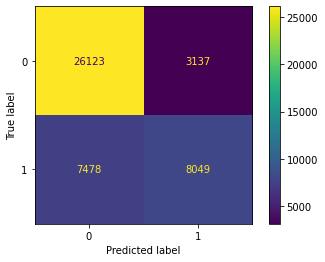

In [10]:
#Plotting Confusion Matrix

from sklearn.metrics import plot_confusion_matrix

pred = rf.predict(X_test_tvec_scaled)

plot_confusion_matrix(rf,X_test_tvec_scaled,y_test)
